In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the latent dimension (number of dimensions in the latent space)
latent_dim = 16  # You can choose any value that suits your problem

# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# Define the mean and log variance layers
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Sampling layer
z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

# Define the encoder and decoder models
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

# VAE model
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")

reconstruction_loss = keras.losses.binary_crossentropy(
    tf.keras.layers.Flatten()(encoder_inputs),
    tf.keras.layers.Flatten()(vae_outputs)
)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer="adam")

# Specify the number of epochs and batch size
epochs = 50
batch_size = 128

# Train VAE
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))


Epoch 1/50
469/469 [==============================] - 120s 251ms/step - loss: 214.7083 - val_loss: 189.4995
Epoch 2/50
469/469 [==============================] - 110s 235ms/step - loss: 182.1242 - val_loss: 176.1511
Epoch 3/50
469/469 [==============================] - 110s 235ms/step - loss: 172.4741 - val_loss: 170.2677
Epoch 4/50
469/469 [==============================] - 112s 238ms/step - loss: 167.4780 - val_loss: 166.1004
Epoch 5/50
469/469 [==============================] - 105s 225ms/step - loss: 164.6384 - val_loss: 163.5730
Epoch 6/50
469/469 [==============================] - 114s 242ms/step - loss: 162.8442 - val_loss: 162.0373
Epoch 7/50
469/469 [==============================] - 122s 260ms/step - loss: 161.3409 - val_loss: 160.6514
Epoch 8/50
469/469 [==============================] - 117s 250ms/step - loss: 160.0056 - val_loss: 159.3291
Epoch 9/50
469/469 [==============================] - 108s 231ms/step - loss: 158.8600 - val_loss: 158.5383
Epoch 10/50
469/469 [=======

In [ ]:
num_samples=10
latent_space_samples = np.random.normal(size=(num_samples, latent_dim))
generated_samples = decoder.predict(latent_space_samples)


1/1 [==============================] - 0s 271ms/step


In [ ]:
generated_samples
import matplotlib.pyplot as plt
plt.show()

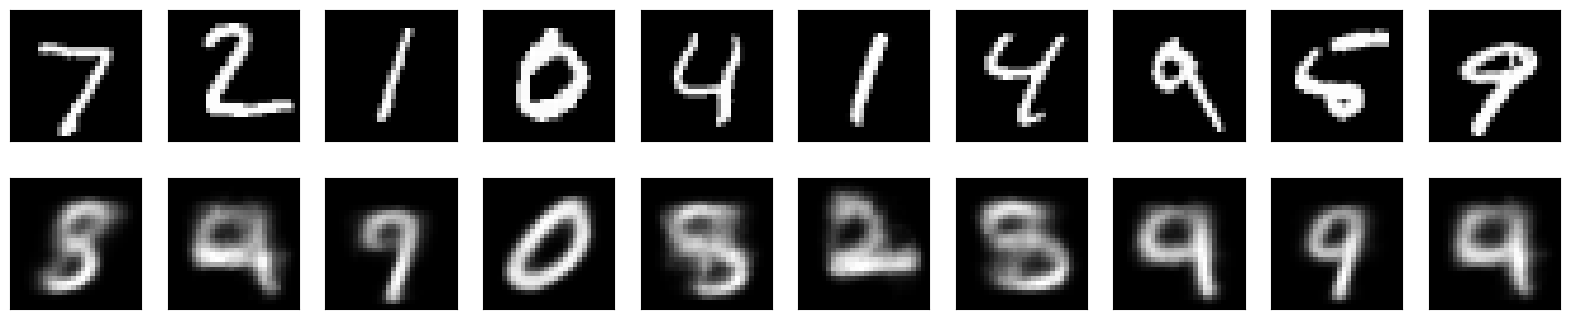

In [ ]:
# Visualize the reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated_samples[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()